In [136]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter

from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    #for i in range(2,20):
    #    assert counter[i]==0
        
    return counter


def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

In [120]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

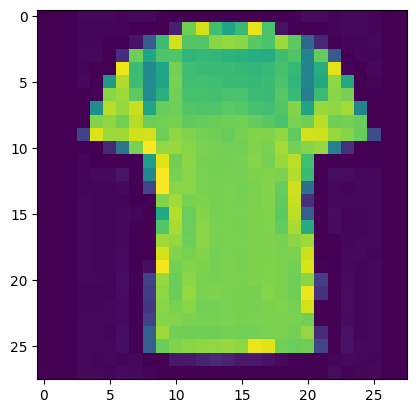

In [121]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
plt.imshow(images[1])

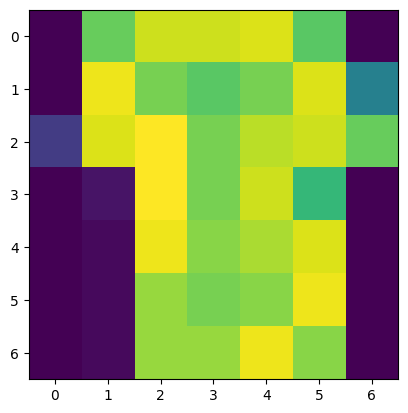

In [122]:
images[1].shape
#max pooling (28x28 -> 8x8)
def max_pooling(image):
    image=np.reshape(image,(28,28))
    new_image=np.zeros((7,7))
    for i in range(7):
        for j in range(7):
            new_image[i,j]=int(np.max(image[i*4:(i+1)*4,j*4:(j+1)*4])*10000)
    return new_image

plt.imshow(max_pooling(images[1]))
#max depooling (8x8 -> 28x28)
def max_depooling(image):
    image=np.reshape(image,(7,7))
    new_image=np.zeros((28,28))
    for i in range(7):
        for j in range(7):
            new_image[i*4:(i+1)*4,j*4:(j+1)*4]=image[i,j]/10000
    return new_image

2.4021936116419106e-06


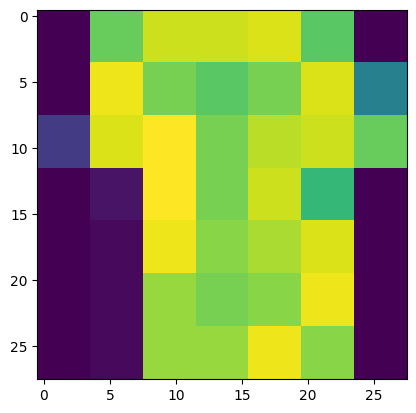

In [123]:
print(image_mse(images[1],max_depooling(max_pooling(images[1]))))
plt.imshow(max_depooling(max_pooling(images[1])))

In [124]:
labels[1]

True

In [125]:
max_pooling(images[200])

array([[ 0.,  7., 25., 39., 27., 22.,  0.],
       [ 0.,  0., 23., 26., 26.,  8.,  0.],
       [ 0.,  0., 20., 19., 23.,  6.,  0.],
       [ 0.,  0., 17., 18., 22., 13.,  0.],
       [ 0.,  0., 17., 19., 22., 24.,  0.],
       [ 0., 10., 19., 21., 21., 26.,  0.],
       [ 0.,  9., 24., 22., 23., 32.,  0.]])

In [176]:
#submission to part 1, you should make this into a .py file
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library.standard_gates import XGate
from qiskit import transpile
n=len(dataset)
mse=0
gatecount=0

custom_gate = QuantumCircuit(1, name='custom_gate')
custom_gate.x(0)
custom_gate_gate = custom_gate.to_gate().control(6)

# Functions 'encode' and 'decode' are dummy.
def encode(image):
    maxPooledImg=max_pooling(image)
    idx = QuantumRegister(3, 'idx')
    idy = QuantumRegister(3, 'idy')
    # grayscale pixel intensity value
    intensity = QuantumRegister(8,'intensity')
    # classical register
    cr = ClassicalRegister(14, 'cr')

    # create the quantum circuit for the image
    qc_image = QuantumCircuit(intensity, idx, idy, cr)

    # set the total number of qubits
    num_qubits = qc_image.num_qubits

    # initialize the qubits
    qc_image.h(range(8,14))
    qc_image.barrier()
    
    for i in range(7):
        for j in range(7):
            for ix,v in enumerate(f'{int(i):b}'.zfill(3)[::-1]):
                if v=='1':
                    qc_image.x([ix+8])
            for iy,v in enumerate(f'{int(j):b}'.zfill(3)[::-1]):
                if v=='1':
                    qc_image.x([iy+11])
            sint=f'{int(maxPooledImg[i,j]):b}'.zfill(8)
            #print(sint)
            for idx, px_value in enumerate(sint[::-1]):
                if px_value=='1':
                    qc_image.append(custom_gate_gate,[8,9,10,11,12,13,idx])
            for ix,v in enumerate(f'{int(i):b}'.zfill(3)[::-1]):
                if v=='1':
                    qc_image.x([ix+8])
            for iy,v in enumerate(f'{int(j):b}'.zfill(3)[::-1]):
                if v=='1':
                    qc_image.x([iy+11])
            qc_image.barrier()
      
    
    qc_image.draw()
    #transpile the circuit
    #qc_image=transpile(qc_image,basis_gates=['cx','u1','u2','u3','id'])
    return qc_image

def decode(histogram):
    # decode the histogram into an image where the keys are the qubit values
    # the first 3 qubits are for the y coordinate
    # the second 3 qubits are for the x coordinate
    # the last 8 qubits are for the grayscale pixel intensity value
    
    print(histogram)
    keys=histogram.keys()
    img=np.zeros((7,7))
    for i in keys:
        si=f'{int(i):b}'.zfill(14)
        print(si)
        x=int(si[8:11],2) if int(si[8:11],2)<7 else 0
        y=int(si[11:14],2) if int(si[11:14],2)<7 else 0
        img[x,y]=int(si[0:8],2)
        image=max_depooling(img)
    return image

def run_part1(image):
    #encode image into a circuit
    circuit=encode(image)

    #simulate circuit
    histogram=simulate(circuit)

    #reconstruct the image
    image_re=decode(histogram)

    return circuit,image_re

In [172]:
cic=encode(images[1])


In [165]:
count_gates(cic)[2]

20116

In [178]:
#how we grade your submission

n=len(dataset)
mse=0
gatecount=0

for data in dataset:
    #encode image into circuit
    circuit,image_re=run_part1(images[1])
    
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    mse+=image_mse(images[1],image_re)
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

{0: 0.015625000000001242, 256: 0.015625000000001235, 512: 0.01562500000000122, 768: 0.015625000000001235, 1024: 0.015625000000001228, 1280: 0.015625000000001242, 1536: 0.015625000000001256, 1792: 0.01562500000000125, 2048: 0.01562500000000526, 2304: 0.0156250000000053, 2560: 0.01562500000000125, 2816: 0.015625000000001263, 3072: 0.01562500000000122, 3358: 0.01562500000000125, 3601: 0.015625000000001235, 3840: 0.015625000000001263, 4096: 0.015625000000001207, 4384: 0.015625000000005204, 4646: 0.01562500000000125, 4901: 0.015625000000005218, 5146: 0.015625000000001284, 5412: 0.015625000000001263, 5669: 0.015625000000001166, 5917: 0.01562500000000125, 6144: 0.01562500000000122, 6438: 0.015625000000001228, 6688: 0.015625000000001242, 6946: 0.01562500000000125, 7204: 0.015625000000001235, 7459: 0.015625000000001235, 7711: 0.015625000000001207, 7973: 0.01562500000000125, 8192: 0.01562500000000125, 8481: 0.01562500000000125, 8735: 0.015625000000005232, 8992: 0.015625000000001166, 9247: 0.0156

TypeError: Singleton array array(None, dtype=object) cannot be considered a valid collection.

In [156]:
data['image']

[[0, 0], [0, 0]]